In [12]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, Input,InputLayer, Activation, BatchNormalization
from keras.layers import AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D, ZeroPadding2D
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

DATA PREPROCESSING AND NORMALIZING

In [13]:
labels = ['NORMAL', 'PNEUMONIA']
img_size = 224

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img = cv2.imread(img_path)
                if img is None:
                    continue  # Skip if the image cannot be loaded

                resized_arr = cv2.resize(img, (img_size, img_size))
                
                contrast = int((177 - 0) * (127 - (-127)) / (254 - 0) + (-127))
                Alpha = float(131 * (contrast + 127)) / (127 * (131 - contrast))
                Gamma = 127 * (1 - Alpha)
                cntrst = cv2.addWeighted(resized_arr, Alpha, resized_arr, 0, Gamma)
                
                data.append([cntrst, class_num])
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
    return np.array(data, dtype=object)


In [ ]:
train = get_data(r"D:\purpose.D drive\pneumoniaxray\xray_chest\train")

x_train = []
y_train = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)


In [14]:
test = get_data(r"D:\purpose.D drive\pneumoniaxray\xray_chest\test")
val = get_data(r"D:\purpose.D drive\pneumoniaxray\xray_chest\val")

In [15]:

x_val=[]
y_val=[]
x_test = []
y_test = []

for feature, label in test:
  x_test.append(feature)
  y_test.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

In [5]:
# Normalize the data
x_train = np.array(x_train,dtype=np.float16) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

In [16]:
x_test = np.array(x_test,dtype=np.float16) / 255
x_val = np.array(x_val,dtype=np.float16) / 255

In [17]:
x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [6]:
# training data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
datagen.fit(x_train)

INCEPTIONV3 MODEL


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import regularizers

# Load the InceptionV3 model without the top layers
inception = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
output = inception.layers[-1].output
output = Flatten()(output)
inception = Model(inception.input, outputs=output)

# Set all layers to be trainable
for layer in inception.layers:
    layer.trainable = True

In [ ]:
# Add custom layers
x = Flatten()(inception.output)
x = Dense(2048, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activity_regularizer=regularizers.l2(1e-5))(x)
x = Dropout(0.5)(x)
x = Dense(2048, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-3), activity_regularizer=regularizers.l2(1e-5))(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-2), activity_regularizer=regularizers.l2(1e-5))(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
inception_model = Model(inputs=inception.input, outputs=predictions)

# Model summary
inception_model.summary()

In [10]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [12]:
# Compile the inception_model
inception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the inception_model
history = inception_model.fit(
    x_train,y_train,
    epochs=10,
    batch_size=16,
    validation_data=(x_test, y_test),
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 1112s 3s/step - accuracy: 0.8985 - loss: 1.6607 - val_accuracy: 0.7981 - val_loss: 2.4210 - learning_rate: 0.0010
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 963s 3s/step - accuracy: 0.9417 - loss: 1.1235 - val_accuracy: 0.5433 - val_loss: 1.9557 - learning_rate: 0.0010
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 1081s 3s/step - accuracy: 0.9489 - loss: 1.1169 - val_accuracy: 0.8077 - val_loss: 1.5197 - learning_rate: 0.0010
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 951s 3s/step - accuracy: 0.9636 - loss: 1.0491 - val_accuracy: 0.6218 - val_loss: 86514.9766 - learning_rate: 0.0010
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 981s 3s/step - accuracy: 0.9489 - loss: 1.1366 - val_accuracy: 0.8029 - val_loss: 1.4904 - learning_rate: 0.0010
Epoch 6/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 972s 3s/step - accuracy: 0.9728 - loss: 1.0265 - val_accuracy: 0.8125 - val_loss: 1.5713 - learning_rate: 0.0010
Epoch 7/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 971s 3s/step - accuracy: 0.9755 - lo

In [13]:
# Save the entire model to a file
model_path = r'D:\purpose.D drive\pneumoniaxray\xray_chest\inceptionsaved.h5'
inception_model.save(model_path)

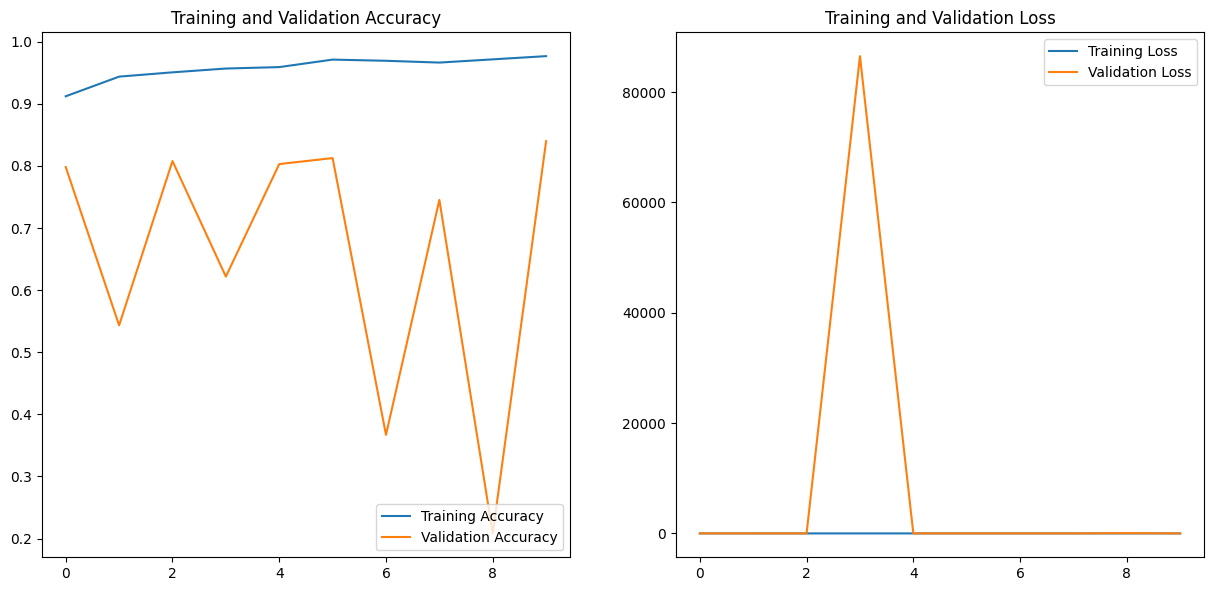

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
from sklearn.metrics import classification_report, accuracy_score

# Load the saved VGG19 model
inception_model = tf.keras.models.load_model(r'D:\purpose.D drive\pneumoniaxray\xray_chest\final upload drive\inceptionv3saved.h5')

# Assuming you have your test data (x_test and y_test)
# Make predictions for the test set
predictions = inception_model.predict(x_test)

# Convert the predicted probabilities to class labels for binary classification
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Ensure y_test is in binary labels format (0 or 1)
y_test_classes = y_test.flatten()  # Flatten if necessary, assuming y_test is already shaped appropriately

# Print the classification report
print(classification_report(y_test_classes, predicted_classes, target_names=['NORMAL (Class 0)', 'PNEUMONIA (Class 1)']))

# Calculate and print the accuracy
accuracy = accuracy_score(y_test_classes, predicted_classes)
print(f"Accuracy: {accuracy:.4f}")

# Calculate and print the precision and recall
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test_classes, predicted_classes, zero_division=1)
recall = recall_score(y_test_classes, predicted_classes, zero_division=1)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step
                     precision    recall  f1-score   support

   NORMAL (Class 0)       0.98      0.48      0.65       234
PNEUMONIA (Class 1)       0.76      0.99      0.86       390

           accuracy                           0.80       624
          macro avg       0.87      0.74      0.76       624
       weighted avg       0.84      0.80      0.78       624

Accuracy: 0.8029
Precision: 0.7623
Recall: 0.9949


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


<Figure size 800x600 with 0 Axes>

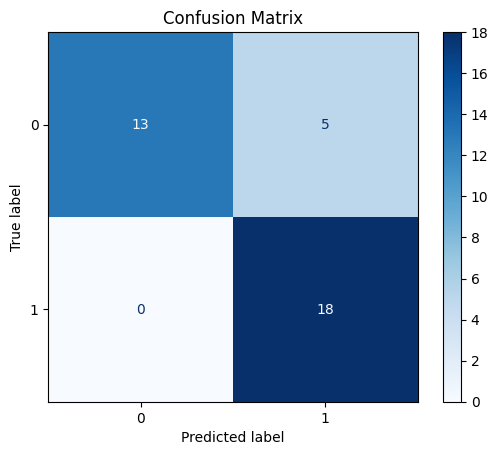

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf



# Assuming you have your validation data (x_val and y_val)
# Make predictions for the validation set
y_pred = inception_model.predict(x_val)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary classes (0 or 1)

# Ensure y_val is in binary labels format (0 or 1)
y_val_classes = y_val.flatten()  # Flatten if necessary, assuming y_val is already shaped appropriately

# Calculate confusion matrix
cm = confusion_matrix(y_val_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Adjust display_labels based on your classes
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [11]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score



# Assuming you have your validation data (x_val and y_val)
# Make predictions for the validation set
y_pred = inception_model.predict(x_val)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary classes (0 or 1)

# Ensure y_val is in binary labels format (0 or 1)
y_val_classes = y_val.flatten()  # Flatten if necessary, assuming y_val is already shaped appropriately

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_val_classes, y_pred_classes)
precision = precision_score(y_val_classes, y_pred_classes)
recall = recall_score(y_val_classes, y_pred_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
Accuracy: 0.8611111111111112
Precision: 0.782608695652174
Recall: 1.0


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Assuming class_names are already defined
class_names = ['Normal', 'Pneumonia']  # Replace with your actual class names


def predict_single_image(model, image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]

    # Predict the image label
    predictions = model.predict(img_array)
    predicted_label = class_names[np.argmax(predictions)]

    # Display the image and predicted label
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


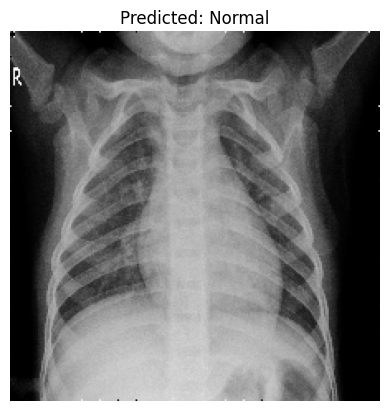

In [15]:
image_path = r'D:\purpose.D drive\pneumoniaxray\NORMAL2-IM-1436-0001.jpeg'
predict_single_image(loaded_model, image_path)